## Descripción
Predicción de síntomas en un paciente con una cepa específica del virus Zika usando datos clínicos específicos y métodos de Machine Learning.
## Métodos
**Procesado de datos**
- Buscar errores o missing values y eliminar estas filas.
    No había ninguno.
- Cambiar escala de features.
    Ya están estandarizadas.
    
- Feature Selection.
    Probamos pero no lo hacemos por ser características médicas.
    
- Balanceo de clases.
    Hacemos undersampling para balancear.
- Separación en conjuntos de entrenamiento, validación y test.

**Machine Learning**

- Use any method of ML / Deep Learning you consider to obtain the best model for your task/problem.
- Use metrics of ML to decide the best model.
- Save the model if possible as file.

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     ParameterGrid, cross_val_score,
                                    learning_curve, ShuffleSplit)
from imblearn.over_sampling import SMOTE
import warnings
import itertools as it
import pickle
import seaborn as sns

In [3]:
# Cargamos dataset
df = pd.read_csv(os.path.join('ds_Zika.csv'))

## Preprocesado de datos

**Comprobamos que no haya "missing values"**

In [4]:
attr = []
# Iteramos los atributos del dataset
for i in df.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(df[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Cálculo de matriz de similitudes**

In [5]:
resultados = np.zeros((len(df.columns), len(df.columns)))

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
            resultados[i, j] = np.mean(df.iloc[:, i] == df.iloc[:, j])

**HeatMap de similitudes**

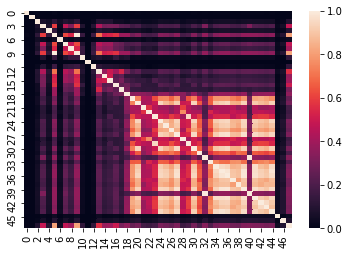

In [ ]:
plt.figure()
x = sns.heatmap(resultados)
plt.show()
plt.close()

**Comprobamos que no haya variables con "near-zero variance"**

In [ ]:
print(df.columns[df.std(axis=0) <= 0.001])

Index(['DSh(I)005_qr', 'DSh(I)009_qr'], dtype='object')


In [ ]:
# Eliminamos esas columnas
df = df.drop(columns=[df.columns[5],df.columns[9]])
resultados = np.delete(resultados, [5,9], axis=0)
resultados = np.delete(resultados, [5,9], axis=1)

**Comprobamos que no haya variables iguales**

In [ ]:
iguales = []
for i, j in it.combinations(range(len(df.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(df.columns[i])
        print(df.columns[i], df.columns[j])

DSh(I)032_qr DSh(I)040_qr


In [ ]:
# Eliminamos esas columnas
df = df.drop(columns=iguales)

**Comprobamos que las clases no estén desbalanceadas**

In [ ]:
# Balanceo de clases
# Comprobamos la proporción
np.mean(df["Output"])

0.18557084417999256

**Undersampling**

In [ ]:
df_u = df.copy()
# Número de casos positivos
nposit = len(df_u[df_u['Output'] == 1])
# Índices de casos negativos
inegat = df_u[df_u.Output == 0].index
# Cogemos aleatoriamente un número de índices negativos igual al número de casos positivos
random_indices = np.random.choice(inegat, nposit, replace=False)
# Obtenemos todos los índices positivos
iposit = df_u[df_u.Output == 1].index
# Unimos las dos listas de índices
new_indices = np.concatenate([iposit, random_indices])
df_u = df_u.loc[new_indices]
# y las desordenamos
df_u = shuffle(df_u).reset_index(drop=True)

X_u = df_u.drop('Output', axis=1)
y_u = df_u['Output']

Xdata_u = X_u.values
ydata_u = y_u.values

**Oversampling**

In [ ]:
df_o = df.copy()
X_o = df_o.drop('Output', axis=1)
y_o = df_o['Output']
Xdata_o = X_o.values
ydata_o = y_o.values
Xdata_o, ydata_o = SMOTE().fit_resample(Xdata_o, ydata_o)

## Entrenamiento de Modelos - Undersampled

In [ ]:
# Suprimimos warnings para legibilidad (nota: no recomendamos hacer esto)
warnings.filterwarnings("ignore")

In [ ]:
# Probamos con undersampling
Xdata = Xdata_u
ydata = ydata_u

### Selección del modelo

In [ ]:
# K Neighbors
knb = KNeighborsClassifier()

# LDC:
ldc = LinearDiscriminantAnalysis()

# Bayesian:
gnb = GaussianNB()

# Multilayer Perceptron
mlp = MLPClassifier()

# SVM:
svm = SVC()

# Random Forest
rndf = RandomForestClassifier()

models = [knb, ldc, gnb, mlp, svm, rndf]
model_names = ['KNeighborsClassifier', 'LinearDiscriminantAnalysis', 'GaussianNB',
               'MLPClassifier', 'SVC', 'RandomForestClassifier']
scores = []
for model in models:
    score = cross_val_score(model, Xdata, ydata, cv=10)
    scores.append((np.mean(score), np.std(score)))
x = pd.DataFrame(np.array(scores), columns=['Mean','Standard Deviation'], index=model_names)
x
# Nos quedamos con RandomForest

,Mean,Standard Deviation
KNeighborsClassifier,0.896778,0.021569
LinearDiscriminantAnalysis,0.874753,0.022985
GaussianNB,0.801146,0.030250
MLPClassifier,0.912298,0.017409
SVC,0.801146,0.030250
RandomForestClassifier,0.924823,0.026092


### Búsqueda de hiperparámetros
- n_estimators: Número de árboles
- max_depth: Profundidad máxima del árbol
- min_samples_leaf: Número mínimo de muestras requeridas en una hoja

In [ ]:
# División entre training y test
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.2,
                                                    stratify=ydata, random_state=1234)
# Hiperparámetros a probar
param_grid = {'n_estimators': range(1, 101, 10),
               'max_depth': range(1, 26, 5),
               'min_samples_leaf': range(1, 11, 5)}

alg = RandomForestClassifier(random_state=1234)
# Grid Search con cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)
grid = GridSearchCV(alg, param_grid=param_grid, cv=cv, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)
print('validation accuracy:', grid.score(X_train, y_train))
print('test accuracy:', grid.score(X_test, y_test))

In [ ]:
# Queremos que haya poca diferencia entre validación y test
c = pd.DataFrame(grid.cv_results_)
c['train_test_difference'] = c.mean_train_score - c.mean_test_score
# Diferencia máxima entre validación y test
max_diff = 0.02
# Precisión mínima en test
min_test_score = 0.90
c_sorted = c[(c.mean_test_score >= min_test_score) & (c.train_test_difference <= max_diff)][(
    ['mean_train_score', 'mean_test_score','train_test_difference'])].sort_values('mean_test_score', ascending=False)
# Ordenamos por error en test
c_sorted.head(n=10)

In [ ]:
# Obtenemos los mejores hiperparámetros según nuestro criterio
i = c_sorted.first_valid_index()
max_depth = c.param_max_depth.iloc[i]
min_samples_leaf = c.param_min_samples_leaf.iloc[i]
n_estimators = c.param_n_estimators.iloc[i]
print('Max depth: {} - Min. samples leaf: {} - Num. estimators: {}'.format(max_depth, min_samples_leaf, n_estimators))

## Resultados - Undersampled

In [ ]:
# Obtenemos el modelo con los hiperparámetros elegidos
alg_u = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

In [ ]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        alg_u, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

In [ ]:
# Cambiamos la división entre training y test
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3,
                                                    stratify=ydata, random_state=1234)
alg_u.fit(X_train, y_train)
print('training accuracy:', alg_u.score(X_train, y_train))
print('test accuracy:', alg_u.score(X_test, y_test))

**Mejores parámetros en función de la precisión en test**

In [ ]:
# Modelo con mejores resultados
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']
n_estimators = grid.best_params_['n_estimators']
best = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

In [ ]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        best, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

## Entrenamiento de modelos - Oversampled

In [ ]:
# Probamos con oversampling:
Xdata = Xdata_o
ydata = ydata_o

### Selección del modelo

In [ ]:
# K Neighbors
knb = KNeighborsClassifier()

# LDC:
ldc = LinearDiscriminantAnalysis()

# Bayesian:
gnb = GaussianNB()

# Multilayer Perceptron
mlp = MLPClassifier()

# SVM:
svm = SVC()

# Random Forest
rndf = RandomForestClassifier()

models = [knb, ldc, gnb, mlp, svm, rndf]
model_names = ['KNeighborsClassifier', 'LinearDiscriminantAnalysis', 'GaussianNB',
               'MLPClassifier', 'SVC', 'RandomForestClassifier']
scores = []
for model in models:
    score = cross_val_score(model, Xdata, ydata, cv=10)
    scores.append((np.mean(score), np.std(score)))
x = pd.DataFrame(np.array(scores), columns=['Mean','Standard Deviation'], index=model_names)
x
# Nos quedamos con RandomForest

### Búsqueda de hiperparámetros

In [ ]:
# División entre training y test
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.2,
                                                    stratify=ydata, random_state=1234)
# Hiperparámetros a probar
param_grid = {'n_estimators': range(1, 101, 10),
               'max_depth': range(1, 26, 5),
               'min_samples_leaf': range(1, 11, 5)}

alg = RandomForestClassifier(random_state=1234)
# Grid Search con cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)
grid = GridSearchCV(alg, param_grid=param_grid, cv=cv, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)
print('validation accuracy:', grid.score(X_train, y_train))
print('test accuracy:', grid.score(X_test, y_test))

In [ ]:
# Queremos que haya poca diferencia entre validación y test
c = pd.DataFrame(grid.cv_results_)
c['train_test_difference'] = c.mean_train_score - c.mean_test_score
# Diferencia máxima entre validación y test
max_diff = 0.02
# Precisión mínima en test
min_test_score = 0.90
c_sorted = c[(c.mean_test_score >= min_test_score) & (c.train_test_difference <= max_diff)][(
    ['mean_train_score', 'mean_test_score','train_test_difference'])].sort_values('mean_test_score', ascending=False)
# Ordenamos por error en test
c_sorted.head(n=10)

In [ ]:
# Obtenemos los mejores hiperparámetros según nuestro criterio
i = c_sorted.first_valid_index()
max_depth = c.param_max_depth.iloc[i]
min_samples_leaf = c.param_min_samples_leaf.iloc[i]
n_estimators = c.param_n_estimators.iloc[i]
print('Max depth: {} - Min. samples leaf: {} - Num. estimators: {}'.format(max_depth, min_samples_leaf, n_estimators))

## Resultados - Oversampled

In [ ]:
# Obtenemos el modelo con los hiperparámetros elegidos
alg_o = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

In [ ]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        alg_o, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

**Mejores parámetros en función de la precisión en test**

In [ ]:
# Modelo con mejores resultados
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']
n_estimators = grid.best_params_['n_estimators']
best = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

In [ ]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        best, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, ypred)

In [ ]:
# Reactivamos warnings
warnings.filterwarnings("default")

## Persistencia

In [ ]:
with open('RForest_Zika_oversampled.bin','wb') as file:
    pickle.dump(alg_o, file)
with open('RForest_Zika_undersampled.bin','wb') as file:
    pickle.dump(alg_u, file)

## FIN